# SOEN 471 - Anime Recommender

## Group project on Big Data

This project is about creating a ***recommender system for Anime***. 
The purpose is to analyze user profiles and suggest an anime that has high probability to fit with their anime watching profiles. 

To create this recommender, we have obtained 2 datasets. 
The first one: **anime.csv** is a csv file that contains a list of animes with numerous features. Details will be presented in the data exploration step. 
The second one: **ratings.csv** is a csv file that contains user ids and their ratings for different animes. 

We can use these information to create a **cross referencing table** that will **map users** who have the same taste of anime **based on their ratings** and **suggest a list of animes** that can fit their profile.

### Step 1 : Data exploration 
During this step, we will look at the data we have on hand, explore all the features and tidy the data to fit our goal. 
#### Anime dataset

In [2]:
##Lets import libraries needed

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
from sklearn.neural_network import MLPRegressor
from sklearn.decomposition import TruncatedSVD 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#import the files and display the content

anime_data = pd.read_csv("/content/drive/MyDrive/anime.csv")

anime_data.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


We can see that our anime data set is composed of 12294 rows and contains 7 columns. 

- anime_id: id to identify the anime
- name: title of the anime
- genre: Genre of the anime
- type: tye of the anime
- episodes: number of episodes of the anime
- rating: average rating out of 10 for this anime, provided by the website provider.
- members: number of community members that follow the particular anime.

Now that we know what our data looks like, let's see some numbers


In [5]:
anime_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


We can see that some of the entries comprise null values. 
Lets **display the sum of all null values** by feature.

In [6]:
anime_data.isnull().sum()

anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

We this, we can see that we have a small number of null values compared to the size of the dataset. 
to deal with the null values we have to options that are type sensitive: either we fill the null values of number with the mean value to keep the data normally distributed or delete those entries. For string values: as the number of null entries is small, we can conduct further research to fill the blanks or also delete these rows. 
We have yet to decide which option to opt for.

With that being said, let's explore the data some more.


In [7]:
anime_data.nunique()

anime_id    12294
name        12292
genre        3264
type            6
episodes      187
rating        598
members      6706
dtype: int64

In [107]:
print(f"Summary of The Anime Dataset :")
anime_data.describe().T.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

Summary of The Anime Dataset :


,count,mean,std,min,25%,50%,75%,max
anime_id,12294.000000,14058.221653,11455.294701,1.000000,3484.250000,10260.500000,24794.500000,34527.000000
rating,12064.000000,6.473902,1.026746,1.670000,5.880000,6.570000,7.180000,10.000000
members,12294.000000,18071.338864,54820.676925,5.000000,225.000000,1550.000000,9437.000000,1013917.000000


#### Ratings dataset
Lets explore the ratings dataset now. 


In [8]:
rating = pd.read_csv('/content/drive/MyDrive/rating.csv')
rating.head()

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1


In [9]:
rating.shape

(7813737, 3)

In [10]:
rating.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [11]:
rating.nunique()

user_id     73515
anime_id    11200
rating         11
dtype: int64

<u>**information about the dataset:**</u>

- user_id : non identifiable randomly generated user id.
- anime_id : the anime that this user has rated.
- rating : rating out of 10 this user has assigned (-1 if the user watched it but didn't assign a rating).

no null values

lets merge the two datasets on anime id

In [12]:
fulldata = pd.merge(anime_data, rating, on='anime_id')
fulldata = fulldata.rename(columns={"rating_y": "user_rating"})
fulldata.drop(["type", "members"], axis=1)



,anime_id,name,genre,episodes,rating_x,user_id,user_rating
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",1,9.37,99,5
1,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",1,9.37,152,10
2,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",1,9.37,244,10
3,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",1,9.37,271,10
4,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",1,9.37,278,-1
...,...,...,...,...,...,...,...
7813722,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,1,4.98,39532,-1
7813723,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,1,4.98,48766,-1
7813724,6133,Violence Gekiga Shin David no Hoshi: Inma Dens...,Hentai,1,4.98,60365,4
7813725,26081,Yasuji no Pornorama: Yacchimae!!,Hentai,1,5.46,27364,-1


In [13]:
fulldata[(fulldata['user_id']==5) & (fulldata['user_rating']!=-1)]

,anime_id,name,genre,type,episodes,rating_x,members,user_id,user_rating
28159,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572,5,9
47442,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266,5,9
61826,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534,5,10
64351,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109,5,8
84786,918,Gintama,"Action, Comedy, Historical, Parody, Samurai, S...",TV,201,9.04,336376,5,9
...,...,...,...,...,...,...,...,...,...
7599135,16636,Kotoura-san: Haruka no Heya,"Comedy, School",ONA,6,6.01,9641,5,5
7615190,8619,Ladies versus Butlers! Tokuten Disc Music Clip,"Ecchi, Music",Special,1,5.90,5676,5,2
7636779,9741,Nana to Kaoru,"Comedy, Ecchi, Romance, Seinen",OVA,1,5.79,12919,5,2
7650287,13479,Uchuu Kyoudai: Apo&#039;s Dream,"Comedy, Sci-Fi, Space",OVA,1,5.62,2323,5,6


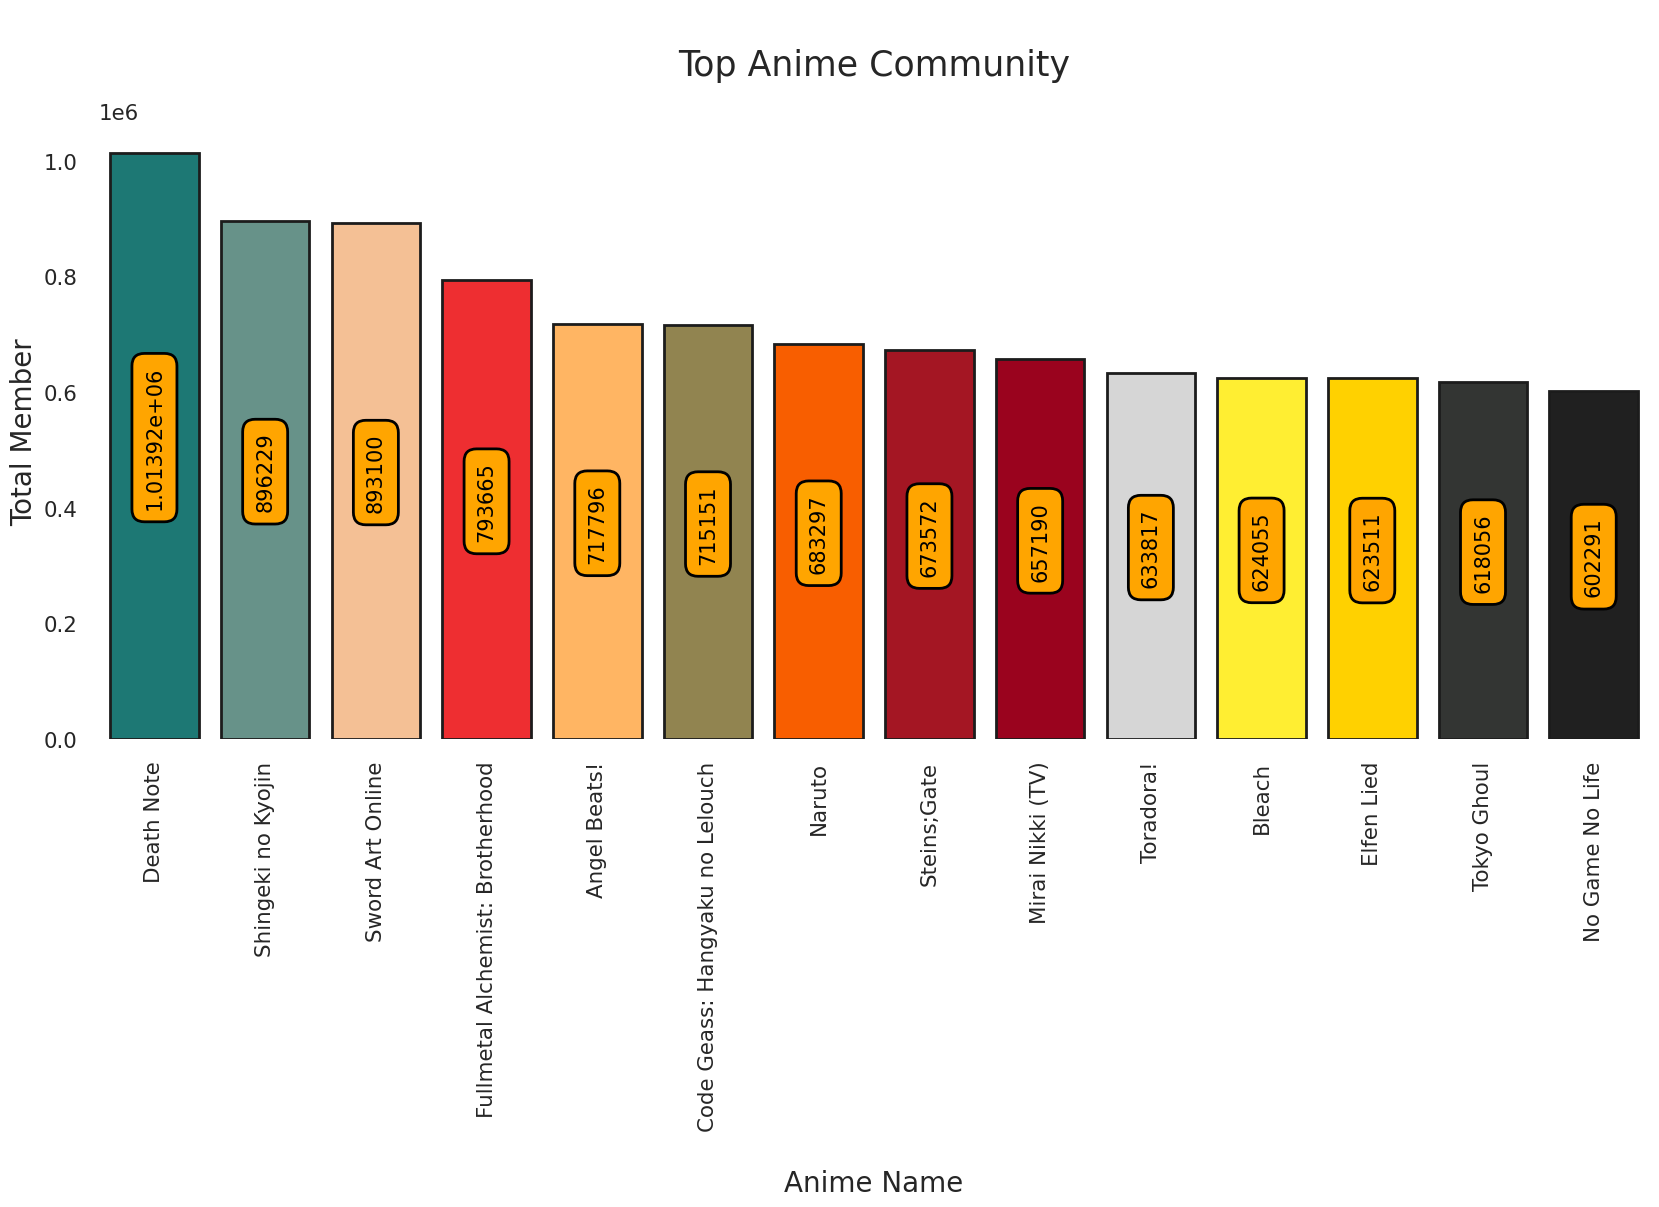

In [110]:
import seaborn as sns

sns.set_style("white")
sns.set_context("poster",font_scale = .7)

palette = ["#1d7874","#679289","#f4c095","#ee2e31","#ffb563","#918450","#f85e00","#a41623","#9a031e","#d6d6d6","#ffee32","#ffd100","#333533","#202020"]
top_anime = fulldata.copy()
top_anime.drop_duplicates(subset ="name", keep = "first", inplace = True)
top_anime_temp1 = top_anime.sort_values(["members"],ascending=False)

plt.subplots(figsize=(20,8))
p = sns.barplot(x=top_anime_temp1["name"][:14],y=top_anime_temp1["members"],palette=palette, saturation=1, edgecolor = "#1c1c1c", linewidth = 2)
p.axes.set_title("\nTop Anime Community\n", fontsize=25)
plt.ylabel("Total Member" , fontsize = 20)
plt.xlabel("\nAnime Name" , fontsize = 20)
# plt.yscale("log")
plt.xticks(rotation = 90)
for container in p.containers:
    p.bar_label(container,label_type = "center",padding = 6,size = 15,color = "black",rotation = 90,
    bbox={"boxstyle": "round", "pad": 0.6, "facecolor": "orange", "edgecolor": "black", "alpha": 1})

sns.despine(left=True, bottom=True)
plt.show()

In [111]:
print("Anime Categories :")
top_anime_temp1["type"].value_counts().to_frame().T.style.set_properties(**{"background-color": "#2a9d8f","color":"white","border": "1.5px  solid black"})

Anime Categories :


,TV,OVA,Special,Movie,ONA,Music
type,2001,1104,718,608,112,48


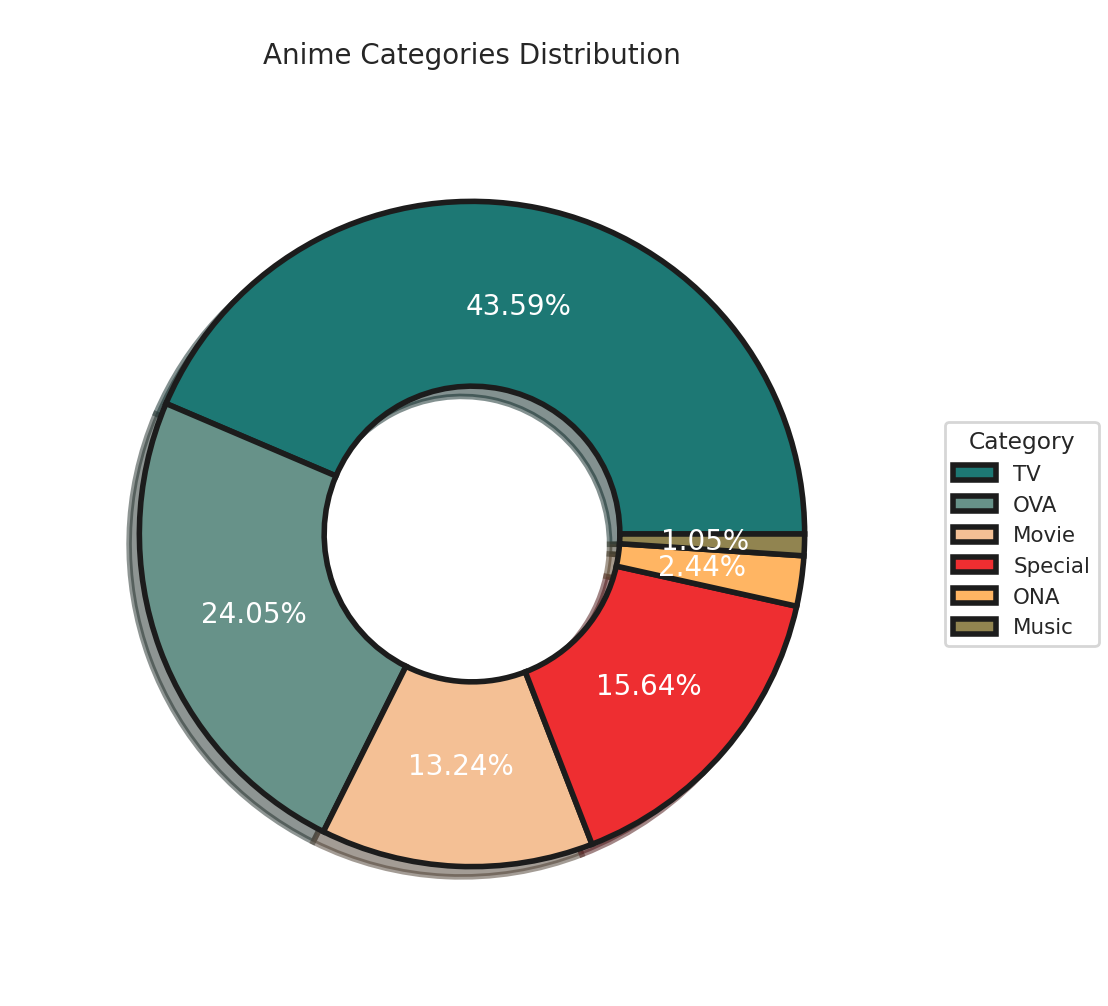

In [112]:
plt.subplots(figsize=(12, 12))

labels = "TV","OVA","Movie","Special","ONA","Music"
size = 0.5

wedges, texts, autotexts = plt.pie([len(top_anime_temp1[top_anime_temp1["type"]=="TV"]["type"]),
                                    len(top_anime_temp1[top_anime_temp1["type"]=="OVA"]["type"]),
                                    len(top_anime_temp1[top_anime_temp1["type"]=="Movie"]["type"]),
                                    len(top_anime_temp1[top_anime_temp1["type"]=="Special"]["type"]),
                                    len(top_anime_temp1[top_anime_temp1["type"]=="ONA"]["type"]),
                                    len(top_anime_temp1[top_anime_temp1["type"]=="Music"]["type"])],
                                    explode = (0,0,0,0,0,0),
                                    textprops=dict(size= 20, color= "white"),
                                    autopct="%.2f%%", 
                                    pctdistance = 0.7,
                                    radius=.9, 
                                    colors = palette, 
                                    shadow = True,
                                    wedgeprops=dict(width = size, edgecolor = "#1c1c1c", 
                                    linewidth = 4),
                                    startangle = 0)

plt.legend(wedges, labels, title="Category",loc="center left",bbox_to_anchor=(1, 0, 0.5, 1))
plt.title("\nAnime Categories Distribution",fontsize=20)
plt.show()

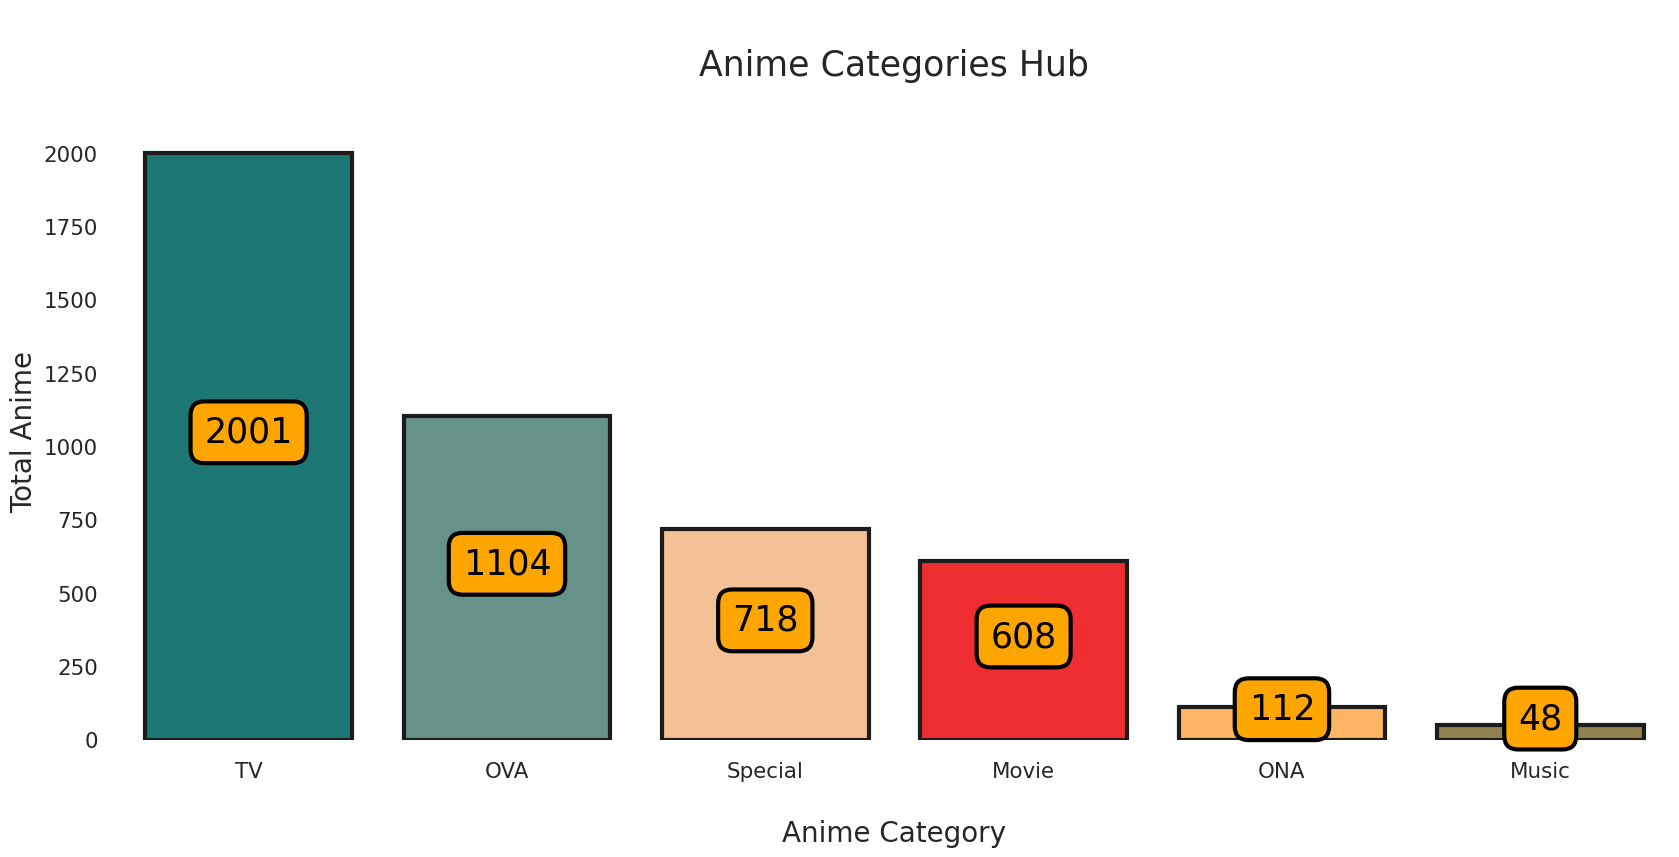

In [113]:
plt.subplots(figsize = (20,8))
p = sns.countplot(x = top_anime_temp1["type"], order = top_anime_temp1["type"].value_counts().index, palette = palette, saturation = 1, edgecolor = "#1c1c1c", linewidth = 3)
p.axes.set_title("\nAnime Categories Hub\n" ,fontsize = 25)
plt.ylabel("Total Anime" ,fontsize = 20)
plt.xlabel("\nAnime Category" ,fontsize = 20)
plt.xticks(rotation = 0)
for container in p.containers:
    p.bar_label(container,label_type = "center",padding = 10,size = 25,color = "black",rotation = 0,
    bbox={"boxstyle": "round", "pad": 0.4, "facecolor": "orange", "edgecolor": "black", "linewidth" : 3, "alpha": 1})

sns.despine(left = True, bottom = True)
plt.show()

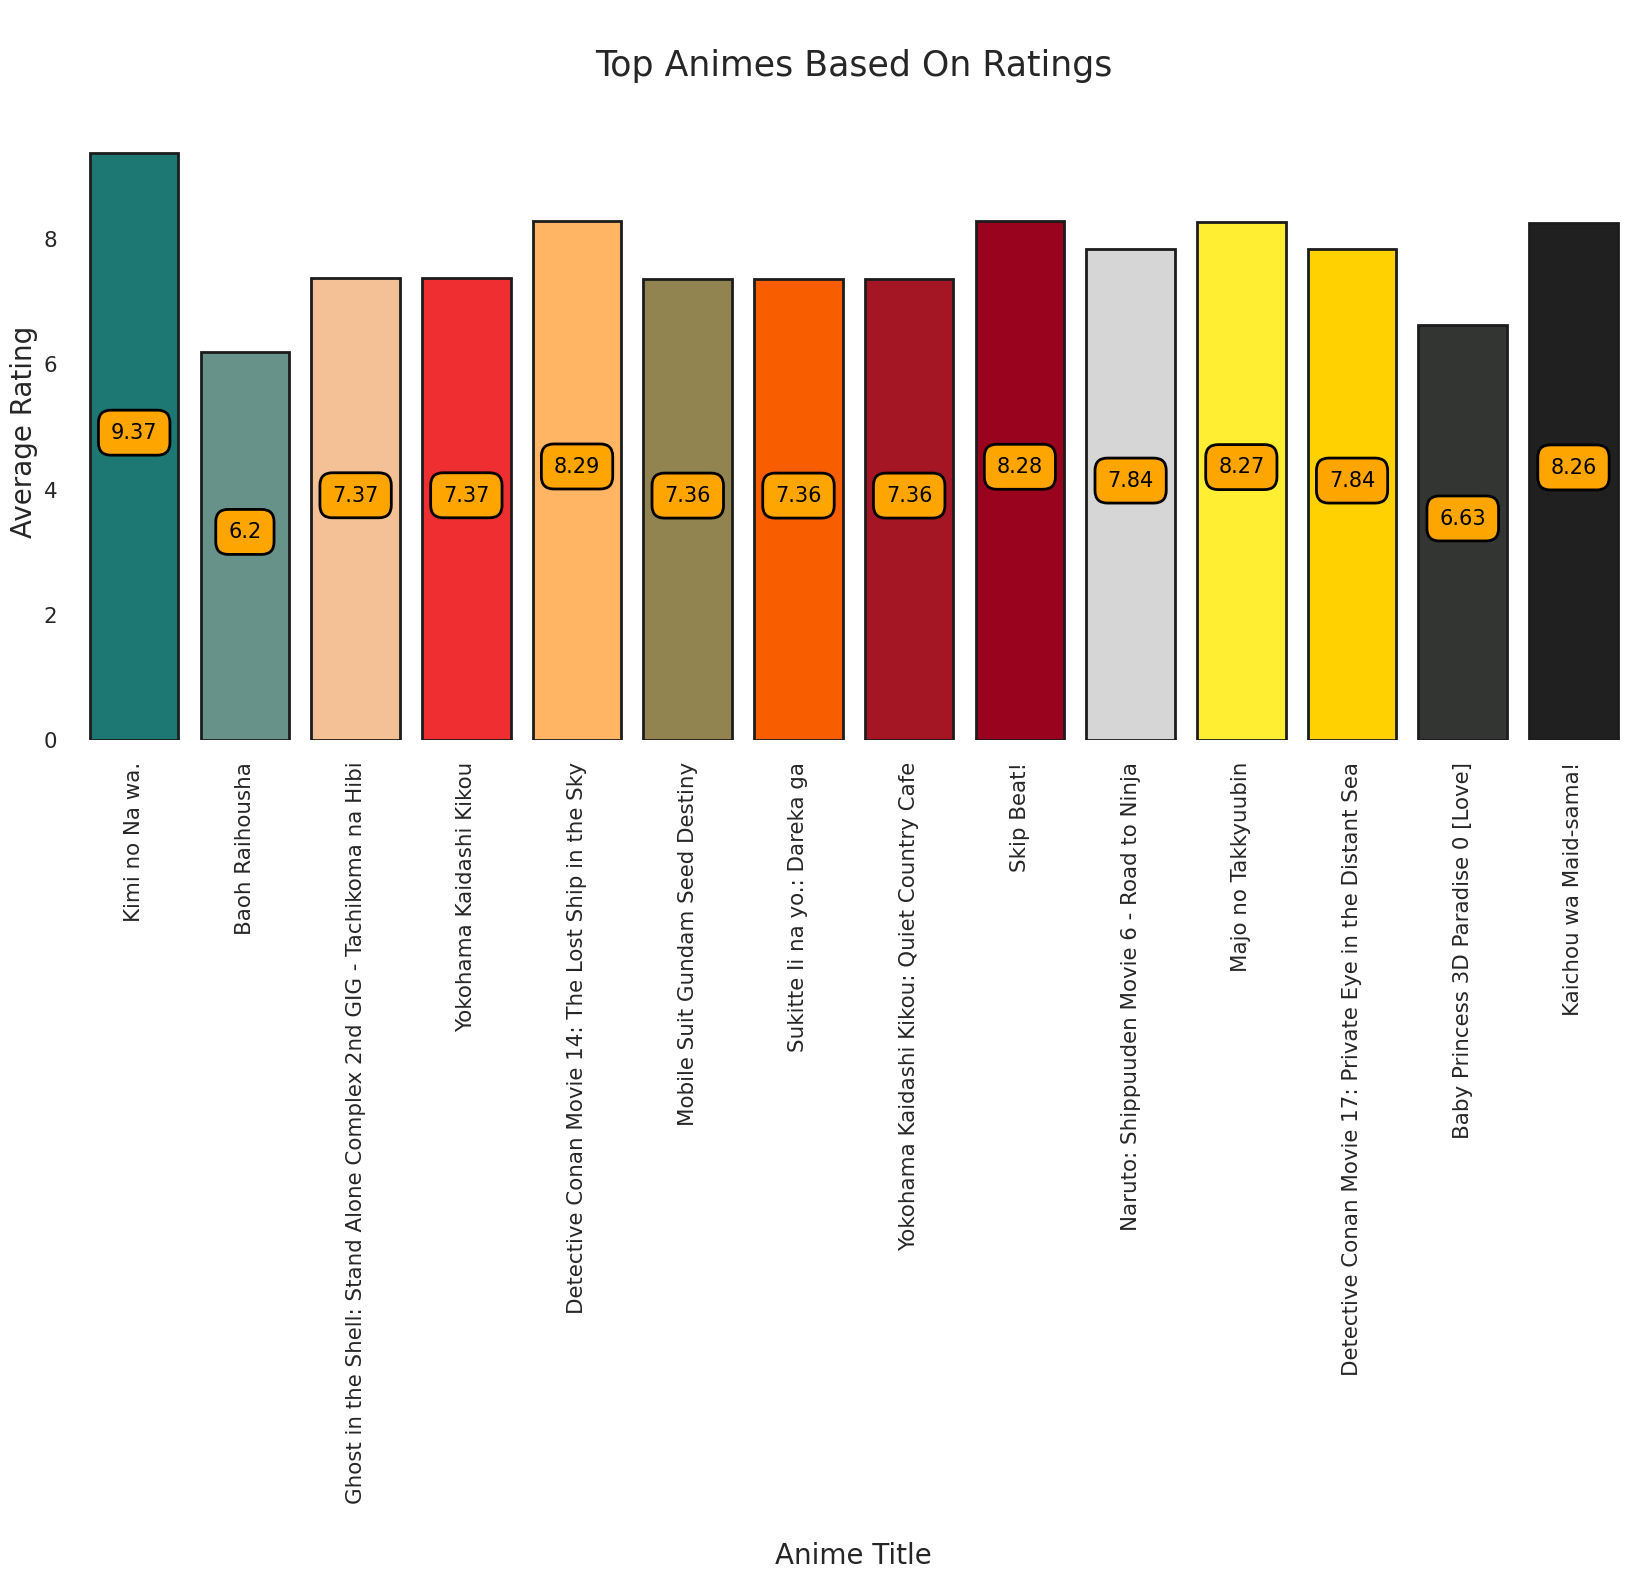

In [121]:
top_anime_temp2 = top_anime.sort_values(["user_rating"],ascending=False)

plt.subplots(figsize=(20,8))
p = sns.barplot(x=top_anime_temp2["name"][:14],y=top_anime_temp2["rating_x"],palette=palette, saturation=1, edgecolor = "#1c1c1c", linewidth = 2)
p.axes.set_title("\nTop Animes Based On Ratings\n",fontsize = 25)
plt.ylabel("Average Rating",fontsize = 20)
plt.xlabel("\nAnime Title",fontsize = 20)
# plt.yscale("log")
plt.xticks(rotation = 90)
for container in p.containers:
    p.bar_label(container,label_type = "center",padding = 10,size = 15,color = "black",rotation = 0,
    bbox={"boxstyle": "round", "pad": 0.6, "facecolor": "orange", "edgecolor": "black", "alpha": 1})

sns.despine(left=True, bottom=True)
plt.show()

Now that the data is all gathered in a dataframe, let's explore how many missing ratings we have in our dataset

In [14]:
null_rating_count = (fulldata['user_rating']==-1).sum()
null_rating_count

1476488

We can notice that many animes are missing ratings. To ensure statistical significance, we need to process more. The problem that could occur is in regards to the correlation that will be implement later on. Suppose an anime has received a score of 10 and is only rated once. When taking the mean, the score will be high and thus create bias. We need to avoid this bias. 
As a first attempt to fix the problem, we will drop all users who have rated less than 200 animes and all animes that have received less that 100 ratings.

In [15]:

# count the number of ratings by user and anime
user_counts = fulldata['user_id'].value_counts()
anime_counts = fulldata['anime_id'].value_counts()

# filter out users who have rated less than 200 animes
users_to_keep = user_counts[user_counts >= 200].index
fulldata = fulldata[fulldata['user_id'].isin(users_to_keep)]

# filter out animes that have received less than 100 ratings
animes_to_keep = anime_counts[anime_counts >= 100].index
fulldata = fulldata[fulldata['anime_id'].isin(animes_to_keep)]

fulldata.shape

(4075024, 9)

This prepocessing step allowed us to move from a dataset of 2.9M+ entries to a 1.3M+ entries. A significant change that could perhaps produce better results. Further analysis will show the efficiency. 

#Extracting the most popular anime for Collaborative Filtering process

Now that our Dataframe is processed, lets extract the most popular anime. This information will be helpful in the upcoming steps. For instance, when caclulating the correlation, it will be based on this anime. 
Furthermore, to ease the handling of Neural Network recommendation system, this popular anime will serve as benchmark.



In [16]:
# the most POPULAR anime by rating.
fulldata.groupby('name')['user_rating'].count().sort_values(ascending=False).head()

name
Death Note                         8714
Angel Beats!                       8471
Sword Art Online                   8441
Code Geass: Hangyaku no Lelouch    8391
Toradora!                          8349
Name: user_rating, dtype: int64

# User-Rating Matrix and Matrix Factorization 

Now that the data is collected and organised, we will proceed to creating the user-rating matrix and implement Matrix factorization. Latent factors can help us extract more features. 

In [17]:
user_ratings_matrix = fulldata.pivot_table(index='user_id', columns='name', values='user_rating')
user_ratings_matrix.head(10)

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,ef: A Tale of Memories. - Recollections,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,-1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.0,7.0,7.0,NaN,NaN,7.0
46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
user_ratings_matrix.replace(-1, np.nan, inplace=True)
user_ratings_matrix.head(10)

name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,ef: A Tale of Memories. - Recollections,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
43,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,8.0,7.0,7.0,NaN,NaN,7.0
46,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
54,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
123,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
129,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


As we will also implement Matrix Factorization, we will create a copy of the user_rating_matrix. This copy will replace all nan values by 0. 
We keep the nan values in the first pivot table as the pearson correlation can extract more feature with unknown values and thus would help us provide better recommendation. However, Matrix Factorization works best when all NaN values are replaced by 0 which explains our approach

In [19]:
MF_user_rating = user_ratings_matrix.copy()
MF_user_rating.fillna(0,inplace=True)

MF_user_rating.head(10)


name,&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,&quot;Bungaku Shoujo&quot; Memoire,&quot;Bungaku Shoujo&quot; Movie,.hack//G.U. Returner,.hack//G.U. Trilogy,.hack//G.U. Trilogy: Parody Mode,.hack//Gift,.hack//Intermezzo,.hack//Liminality,.hack//Quantum,...,ef: A Tale of Memories.,ef: A Tale of Memories. - Prologue,ef: A Tale of Memories. - Recollections,iDOLM@STER Xenoglossia,s.CRY.ed,xxxHOLiC,xxxHOLiC Kei,xxxHOLiC Movie: Manatsu no Yoru no Yume,xxxHOLiC Rou,xxxHOLiC Shunmuki
user_id,,,,,,,,,,,,,,,,,,,,,
5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0
7,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
17,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
43,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,8.0,7.0,7.0,0.0,0.0,7.0
46,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
123,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
129,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
MF_user_rating.shape

(11278, 4591)

As we will apply a the SVD to MF_user_rating, we need to transpose the matrix to have the users in column. The SVD will be applied to the columns in order to reduce the dimensionalty and alos, generalize the viewers rating


In [21]:
MF_user_rating_transposed = MF_user_rating.T
MF_user_rating_transposed.shape

(4591, 11278)

In [22]:
MF_user_rating_transposed

user_id,5,7,17,38,43,46,54,123,129,139,...,73460,73462,73476,73477,73485,73491,73499,73502,73503,73507
name,,,,,,,,,,,,,,,,,,,,,
&quot;Bungaku Shoujo&quot; Kyou no Oyatsu: Hatsukoi,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Memoire,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
&quot;Bungaku Shoujo&quot; Movie,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0
.hack//G.U. Returner,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
.hack//G.U. Trilogy,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
xxxHOLiC,2.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,7.0,0.0,0.0,7.0,0.0,0.0,10.0,8.0,10.0
xxxHOLiC Kei,0.0,0.0,0.0,0.0,7.0,0.0,0.0,0.0,0.0,0.0,...,0.0,9.0,0.0,0.0,8.0,0.0,0.0,10.0,8.0,9.0
xxxHOLiC Movie: Manatsu no Yoru no Yume,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,8.0,0.0,0.0,8.0,0.0,0.0,10.0,0.0,9.0


In [23]:
svd = TruncatedSVD(n_components=100, n_iter=100, random_state=0)
X_svd = svd.fit_transform(MF_user_rating_transposed)

Now that the SVD model is trained, we can proceed with the collaborative filtering recommendation. 
We will now produce a correlation matrix. 

In [24]:
# PearsonR coef 
corr_matrix = np.corrcoef(X_svd)
corr_matrix.shape

(4591, 4591)

In [25]:
corr_matrix

array([[1.        , 0.96908986, 0.90291281, ..., 0.49727288, 0.4702    ,
        0.46140321],
       [0.96908986, 1.        , 0.94458178, ..., 0.45940659, 0.47442835,
        0.44691656],
       [0.90291281, 0.94458178, 1.        , ..., 0.42619488, 0.43868719,
        0.41634117],
       ...,
       [0.49727288, 0.45940659, 0.42619488, ..., 1.        , 0.93434547,
        0.96187395],
       [0.4702    , 0.47442835, 0.43868719, ..., 0.93434547, 1.        ,
        0.98744711],
       [0.46140321, 0.44691656, 0.41634117, ..., 0.96187395, 0.98744711,
        1.        ]])

In [26]:
# get the index of the popular anime
anime_names = MF_user_rating.columns
anime_list = list(anime_names)

popular_anime = anime_list.index('Death Note')
print("index of the popular anime: ", popular_anime) 

index of the popular anime:  836


In [27]:
# anime of interest 
corr_popular_anime = corr_matrix[popular_anime]
corr_popular_anime.shape  

(4591,)

In [29]:
list(anime_names[(corr_popular_anime < 1.0) & (corr_popular_anime > 0.878)])

['Angel Beats!',
 'Code Geass: Hangyaku no Lelouch',
 'Code Geass: Hangyaku no Lelouch R2',
 'Elfen Lied',
 'Fullmetal Alchemist: Brotherhood',
 'Shingeki no Kyojin']

And There you go!! Our ***first*** recommendation system based on SVD is done :

Now we will implement a Neural Network based model and compare the results over the same top rated anime (Death Note)

#Neural Network Based Recommendation System

In this phase, we will implement an MultiLayerPerceptron model. As any other neural network model, it requires setting up the right hyperparameters. To attain the best efficiency possible, we will conduct a gridsearch fro the best Learning rate and number of Neurons. This step is very expensive but will hopefully help us choose the right setup.

##Preprocesing further 
First part is to encode our data to fit the NN requirments. As our data includes text, we need to process the data more for it to be readable by the NN. Therefore, we will be using the LableEncoder from Scikit.learn prepreocessing. 

In [30]:
from sklearn.preprocessing import LabelEncoder


#copy the dataframe 
NN_data = fulldata.copy()

anime_encoder = LabelEncoder()
NN_data['anime_name'] = anime_encoder.fit_transform(NN_data['name'].values)

# Compute the mean anime ratings
anime_mean_ratings = fulldata.groupby('anime_id')['user_rating'].mean()

# Replace -1 values with the corresponding anime mean ratings
NN_data['user_rating'] = NN_data.apply(lambda row: anime_mean_ratings[row['anime_id']] if row['user_rating'] == -1 else row['user_rating'], axis=1)


NN_data['user_rating'] = NN_data['user_rating'].values.astype(np.float32)

min_rating = min(NN_data['user_rating'])
max_rating = max(NN_data['user_rating'])

print(min_rating, max_rating)





1.0 10.0


In [31]:
NN_data.isna().sum()

anime_id       0
name           0
genre          0
type           0
episodes       0
rating_x       0
members        0
user_id        0
user_rating    0
anime_name     0
dtype: int64

Now that the data is properly formated to meet NN requirments, lets split the data in train and test and proceed with the training.

In [56]:
X = NN_data[['user_id', 'anime_name']].values
y = NN_data['user_rating'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((3260019, 2), (815005, 2), (3260019,), (815005,))

***Keras implementation***

In [55]:
n_factors = 50

X_train_array = [X_train[:, 0], X_train[:, 1]]
X_test_array = [X_test[:, 0], X_test[:, 1]]

In [69]:
from keras.layers import Add, Activation, Lambda
from keras.models import Model
from keras.layers import Input, Reshape, Dot
from keras.layers import Embedding, Concatenate, Flatten, multiply
from keras.optimizers import Adam
from keras.regularizers import l2

class EmbeddingLayer:
    def __init__(self, n_items, n_factors):
        self.n_items = n_items
        self.n_factors = n_factors
    
    def __call__(self, x):
        x = Embedding(self.n_items, self.n_factors, embeddings_initializer='he_normal', embeddings_regularizer=l2(1e-6))(x)
        x = Reshape((self.n_factors,))(x)
        
        return x
    
def Recommender(n_users, n_anime, n_factors, min_rating, max_rating):
    user = Input(shape=(1,))
    u = EmbeddingLayer(n_users, n_factors)(user)
    ub = EmbeddingLayer(n_users, 1)(user)
    
    anime = Input(shape=(1,))
    m = EmbeddingLayer(n_anime, n_factors)(anime)
    mb = EmbeddingLayer(n_anime, 1)(anime)   
    
    x = Dot(axes=1)([u, m])
    x = Add()([x, ub, mb])
    x = Activation('sigmoid')(x)
    x = Lambda(lambda x: x * (max_rating - min_rating) + min_rating)(x)  
    
    model = Model(inputs=[user, anime], outputs=x)
    opt = Adam(lr=0.001)
    model.compile(loss='mean_squared_error', optimizer=opt)  
    
    return model

In [62]:
n_users = NN_data['user_id'].nunique()

n_anime = NN_data['anime_name'].nunique()

keras_model = Recommender(n_users, n_anime, n_factors, min_rating, max_rating)
keras_model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 input_8 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 1, 50)        563900      ['input_7[0][0]']                
                                                                                                  
 embedding_14 (Embedding)       (None, 1, 50)        229550      ['input_8[0][0]']                
                                                                                            

/usr/local/lib/python3.9/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [ ]:
keras_model.fit(x=X_train_array, y=y_train, batch_size=100, epochs=5, validation_data=(X_test_array, y_test), )

#Random forest Model
Now we will train a second recommender system using the random forest algorithm. Random forest is an algorithm that combines the predictions of multiple decision trees to predict a particular variable or class of an item. In our case the random forests predict the rating of each anime for each user. 

In [80]:
from sklearn.ensemble import RandomForestRegressor

Let's first create a basic random forest regressor and train it with the test set.

In [81]:
rf = RandomForestRegressor(random_state = 42, n_estimators=10, max_depth=5)

In [82]:
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=5, n_estimators=10, random_state=42)

Now evaluate the model:

In [83]:
y_predict_rf = rf.predict(X_test)
print("rmse:", mean_squared_error(y_test, y_predict_rf, squared=False))
print("mean abs error:", mean_absolute_error(y_test, y_predict_rf))

rmse: 1.606707572709831
mean abs error: 1.3132697969926976


##Tuning hyperparameters

The model works, but we can improve it further by tuning the hyperparameters. 

Give Range of estimators, run with many combination of the features

In [84]:
rf_grid = RandomForestRegressor(random_state = 42)

In [85]:
tune_parameters = [{'n_estimators': [10,30,50],
                    'max_depth': [10,15,16,20],
                    'min_samples_split':[2,5,8],
                    'min_samples_leaf':[1,2,4],
                    'max_features':['auto','sqrt']}]

In [86]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

Searching for the best parameter from combinations - tells us which parameter gives the best accurary


In [87]:
rf_grid_cv = GridSearchCV(estimator = rf_grid, param_grid = tune_parameters, cv = 5, verbose = 1)

In [88]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(3260019, 2)
(815005, 2)
(3260019,)
(815005,)


In [89]:
tune_param = {
 'max_depth': [5, 10],
 'max_features': ['auto', 'sqrt'],
 'min_samples_split': [2, 5],
 'n_estimators': [5]}

In [90]:
rf = RandomForestRegressor()

In [94]:
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = tune_param, n_iter = 10, cv = 3, verbose = 1, random_state = 0, n_jobs = -1)

In [95]:
rf_random.fit(X_train, y_train)

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 3 folds for each of 8 candidates, totalling 24 fits


/usr/local/lib/python3.9/dist-packages/sklearn/ensemble/_forest.py:413: FutureWarning: `max_features='auto'` has been deprecated in 1.1 and will be removed in 1.3. To keep the past behaviour, explicitly set `max_features=1.0` or remove this parameter as it is also the default value for RandomForestRegressors and ExtraTreesRegressors.
  warn(


RandomizedSearchCV(cv=3, estimator=RandomForestRegressor(), n_jobs=-1,
                   param_distributions={'max_depth': [5, 10],
                                        'max_features': ['auto', 'sqrt'],
                                        'min_samples_split': [2, 5],
                                        'n_estimators': [5]},
                   random_state=0, verbose=1)

This gives the best features (Best parameters)

In [97]:
rf_random.best_params_

{'n_estimators': 5,
 'min_samples_split': 2,
 'max_features': 'auto',
 'max_depth': 10}

In [98]:
rf = RandomForestRegressor(max_depth = 500,
 max_features = 'sqrt',
 min_samples_split = 30,
 n_estimators = 15)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=500, max_features='sqrt', min_samples_split=30,
                      n_estimators=15)

In [99]:
y_predict_rf = rf.predict(X_test)
print("rmse:", mean_squared_error(y_test, y_predict_rf, squared=False))
print("mean abs error:", mean_absolute_error(y_test, y_predict_rf))

rmse: 1.388670397766774
mean abs error: 1.1118481612996638


In [101]:
rf = RandomForestRegressor(max_depth = 2000,
 max_features = 'sqrt',
 min_samples_split = 20,
 n_estimators = 30)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=2000, max_features='sqrt', min_samples_split=20,
                      n_estimators=30)

In [103]:
y_predict_rf = rf.predict(X_test)
print("rmse:", mean_squared_error(y_test, y_predict_rf, squared=False))
print("mean abs error:", mean_absolute_error(y_test, y_predict_rf))

rmse: 1.3735998559630858
mean abs error: 1.0950369998637668


##Plotting the decision trees
Now that we have the random forest model with tuned hyperparameters, we can plot a few of its decision trees. For this we will use graphviz.

In [104]:
!apt-get install graphviz
import graphviz
from sklearn import tree


Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.42.2-3build2).
0 upgraded, 0 newly installed, 0 to remove and 24 not upgraded.


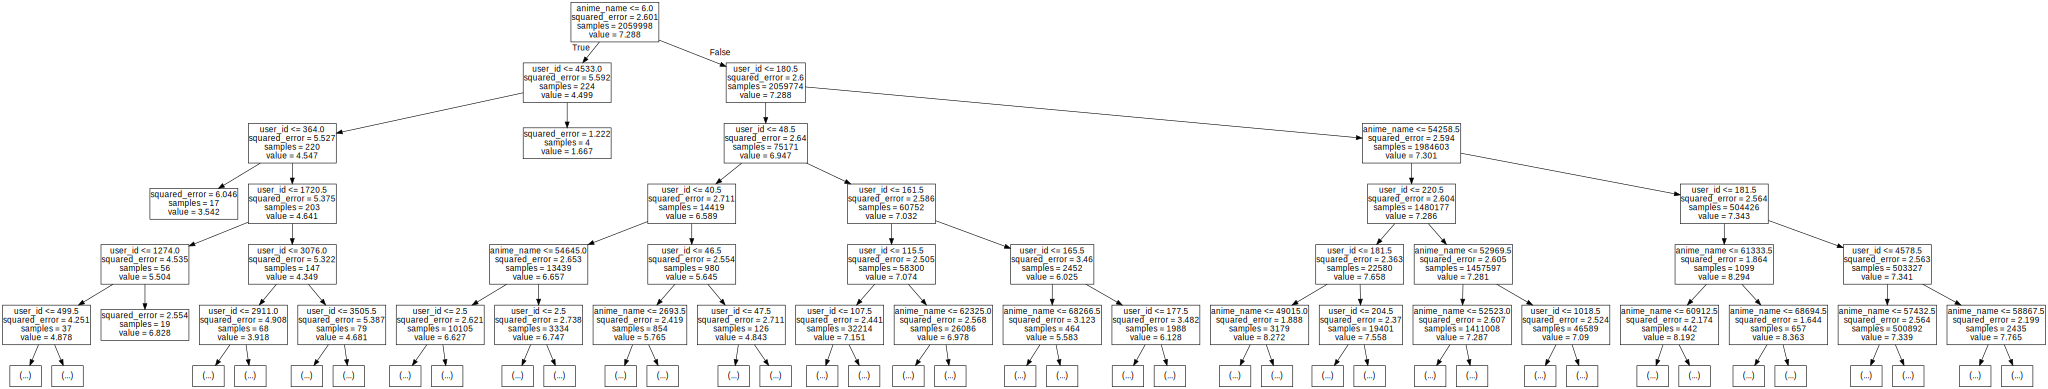

In [105]:
rf_tree_plot = tree.export_graphviz(rf.estimators_[0], max_depth=5, feature_names=["anime_name", "user_id"])
graph = graphviz.Source(rf_tree_plot)
graph

This tree shows the first few nodes of a deep decision tree.

Note that it may seem that the tree is treating categorical features as ordinal. This is a problem in shallow trees, however deep random forests can handle categorical features without the need of one hot encoding.

In [ ]:
rf_tree_plot = tree.export_graphviz(rf.estimators_[0], max_depth=100, feature_names=["anime_name", "user_id"])
graph = graphviz.Source(rf_tree_plot)
graph

# Evaluation
tbc

#Sources
https://scikit-learn.org/

https://towardsdatascience.com/one-hot-encoding-is-making-your-tree-based-ensembles-worse-heres-why-d64b282b5769
